# Using El Nino Southern Oscillation (ENSO) Information To Predict Water Levels in Norfolk, VA

## Introduction and Motivation: 

### [COPY INFO FROM PRESENTATION SLIDES]

## Data and Methods

- Data Sources:


    * El Nino data: Oceanic Nino Index (ONI) from from the National Oceanic and Atmospheric Administration (NOAA)
        [http://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php]

    * Southern Oscillation data: Southern Oscillation Index (SOI) from NOAA
        [http://www.cpc.ncep.noaa.gov/data/indices/soi]

    * Water level data: Sewell's Point, VA tidal gauge data from NOAA
        [https://tidesandcurrents.noaa.gov/stationhome.html?id=8638610]

- Methodology:


    * Our period of record will consist of monthly data for years 1996-2017 (existing gauge installed Dec. 1995).

## Preprocessing

First step is to acquire input data, and read into pandas data frames; 
here we'll be using:

    a) standardized monthly sea-level pressure anomalies (SOI) for our ENSO metric, and 

    b) maximum verified monthly water level above the station's Mean Lower Low Water (MLLW) datum, in meters. 
    NOAA defines MLLW as 
> *"the average of the lower low water height of each tidal day observed over the National Tidal Datum Epoch."* 

In [1]:
# Imports and constants
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

soi_url="http://www.cpc.ncep.noaa.gov/data/indices/soi"
wlev_url='https://raw.githubusercontent.com/skydog71/CMSC641_tutorial/master/wlev_sewells_pt_monthly_1996-2017.csv'


In [2]:
# Read in SOI data, and narrow period of record to ours (1996-2017)
soi_df = pd.read_csv(soi_url,sep='  ',header=2, engine='python')
soi_df = soi_df[45:67].astype(float)

# Rename columns (to remove superfluous spaces)
soi_df.columns = ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

soi_df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
45,1996.0,1.6,0.4,1.9,1.3,0.5,1.9,1.1,1.2,1.0,1.0,-0.1,1.5
46,1997.0,0.8,2.9,-0.7,-1.0,-2.2,-2.3,-1.2,-2.4,-2.4,-2.4,-2.0,-1.6
47,1998.0,-4.4,-3.4,-4.0,-2.4,0.4,1.6,2.0,1.9,1.7,1.8,1.7,2.3
48,1999.0,3.0,1.6,2.1,2.3,0.4,0.4,0.9,0.6,-0.1,1.6,1.7,2.4
49,2000.0,1.1,2.7,2.2,2.0,0.6,-0.3,-0.3,1.2,1.4,1.8,3.0,1.3


In [3]:
# Read in water level data, which have been time-sampled down to our record of interest (1996-2017)
wlev_df = pd.read_csv(wlev_url, header=0, engine='python')
wlev_df.head(12)

,Year,Month,Highest,MHHW,MHW,MSL,MTL,MLW,MLLW,DTL,GT,MN,DHQ,DLQ,HWI,LWI,Lowest,Inferred
0,1996,1,1.251,0.884,0.818,0.457,0.454,0.091,0.036,0.460,0.848,0.727,0.066,0.055,1.60,7.86,-0.216,0
1,1996,2,1.374,0.818,0.749,0.384,0.378,0.008,-0.042,0.388,0.860,0.741,0.069,0.050,1.57,7.87,-0.309,0
2,1996,3,1.053,0.796,0.738,0.377,0.373,0.008,-0.047,0.375,0.843,0.730,0.058,0.055,1.56,7.84,-0.608,0
3,1996,4,1.134,0.827,0.769,0.404,0.399,0.029,-0.008,0.409,0.835,0.740,0.058,0.037,1.55,7.82,-0.231,0
4,1996,5,1.167,0.865,0.814,0.436,0.430,0.046,0.015,0.440,0.850,0.768,0.051,0.031,1.51,7.77,-0.192,0
5,1996,6,1.102,0.881,0.828,0.450,0.444,0.059,0.036,0.458,0.845,0.769,0.053,0.023,1.44,7.74,-0.126,0
6,1996,7,1.131,0.873,0.815,0.429,0.420,0.025,-0.008,0.432,0.881,0.790,0.058,0.033,1.47,7.82,-0.224,0
7,1996,8,1.138,0.935,0.898,0.506,0.498,0.099,0.078,0.506,0.857,0.799,0.037,0.021,1.45,7.77,-0.072,0
8,1996,9,1.252,1.072,1.019,0.648,0.641,0.264,0.227,0.649,0.845,0.755,0.053,0.037,1.50,7.79,-0.045,0
9,1996,10,1.540,1.024,0.975,0.601,0.597,0.220,0.178,0.601,0.846,0.755,0.049,0.042,1.55,7.79,-0.083,0


There's some superfluous info here -- all we'll be working with in this tutorial is the "Highest" column, which is the maximum water level for a given month. 

In addition, it would make things clearer to transpose the data such that series are arranged like the SOI dataframe.

In [4]:
# Transpose each month's 'Highest' data
jan_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 1.])
feb_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 2.])
mar_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 3.])
apr_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 4.])
may_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 5.])
jun_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 6.])
jul_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 7.])
aug_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 8.])
sep_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 9.])
oct_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 10.])
nov_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 11.])
dec_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 12.])

# Construct our transposed dataframe
wlev_transposed_df = pd.DataFrame(
    {'JAN' : jan_data,
     'FEB' : feb_data,
     'MAR' : mar_data,
     'APR' : apr_data,
     'MAY' : may_data,
     'JUN' : jun_data,
     'JUL' : jul_data,
     'AUG' : aug_data,
     'SEP' : sep_data,
     'OCT' : oct_data,
     'NOV' : nov_data,
     'DEC' : dec_data
    })

*separator*

In [5]:
### REMOVE THIS CELL BEFORE SUBMITTING ###

##This would also be a good time to standardize the data (this was unnecessary with the SOI data, as they were provided by NOAA as standardized anomalies).
# We use a pipeline to a) impute any missing data with the median (doesn't look like anything's missing here, but 
# this improves reusability); and b) standardize each month's data individually
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer
#from sklearn_pandas import DataFrameMapper
#
#num_attributes = [x for x in list(wlev_transposed_df)]
#
#num_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
#])
#
#full_pipeline = DataFrameMapper([
#    (num_attributes, num_pipeline)
#])
#
#wlev_clean = full_pipeline.fit_transform(wlev_transposed_df)
#years = np.array(range(1996,2018))
# Construct final (tranposed, imputed, and standardized) water level dataframe
#wlev_clean_df = pd.DataFrame(
#    {'YEAR' : years,
#     'JAN' : wlev_clean[:,0],
#     'FEB' : wlev_clean[:,1],
#     'MAR' : wlev_clean[:,2],
#     'APR' : wlev_clean[:,3],
#     'MAY' : wlev_clean[:,4],
#     'JUN' : wlev_clean[:,5],
#     'JUL' : wlev_clean[:,6],
#     'AUG' : wlev_clean[:,7],
#     'SEP' : wlev_clean[:,8],
#     'OCT' : wlev_clean[:,9],
#     'NOV' : wlev_clean[:,10],
#     'DEC' : wlev_clean[:,11]
#    })
#wlev_clean_df.head(12)

In [6]:
# Construct final tranposed water level dataframe
years = np.array(range(1996,2018))
wlev_clean_df = pd.DataFrame(
    {'YEAR' : years,
     'JAN' : jan_data,
     'FEB' : feb_data,
     'MAR' : mar_data,
     'APR' : apr_data,
     'MAY' : may_data,
     'JUN' : jun_data,
     'JUL' : jul_data,
     'AUG' : aug_data,
     'SEP' : sep_data,
     'OCT' : oct_data,
     'NOV' : nov_data,
     'DEC' : dec_data
    })
wlev_clean_df.head(12)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1996,1.251,1.374,1.053,1.134,1.167,1.102,1.131,1.138,1.252,1.540,1.330,1.315
1,1997,1.054,1.338,1.104,1.591,1.138,1.483,1.203,1.122,1.112,1.689,1.340,1.313
2,1998,1.840,2.004,1.215,1.475,1.490,1.094,1.041,1.688,1.255,1.089,1.182,1.118
3,1999,1.206,1.192,1.383,1.137,1.515,1.227,1.269,1.705,1.820,1.163,1.069,1.128
4,2000,1.667,0.912,1.326,1.515,1.617,1.156,1.174,1.236,1.425,1.147,1.259,1.010
5,2001,0.993,0.931,1.203,1.099,1.232,1.024,1.273,1.069,1.390,1.471,1.009,1.066
6,2002,1.142,1.084,1.107,1.183,0.996,1.143,1.089,1.116,1.195,1.433,1.182,1.225
7,2003,1.257,1.396,1.366,1.518,1.338,1.219,1.051,0.977,2.404,1.416,1.361,1.175
8,2004,1.094,1.136,1.329,1.054,1.018,1.196,1.148,1.293,1.377,1.382,1.561,1.283
9,2005,1.205,1.268,1.182,1.291,1.523,1.237,1.144,1.161,1.255,1.460,1.060,1.145


## Exploratory Data Analysis

Data are now ready for exploratory analysis. First step is to make some plots. It may be useful here to look at plots during the three phases of ENSO (Warm, Neutral and Cold):

    a) NEED TO FIGURE OUT HOW TO MATCH LAGGED ENSO DATA TO CONTEMPORARY WATER HEIGHTS 

    b) HOW TO LABEL WARM/NEUTRAL/COLD -- based on official NOAA designations? Necessary?

### Let's first plot histograms of the data to get an overall picture of our datasets

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

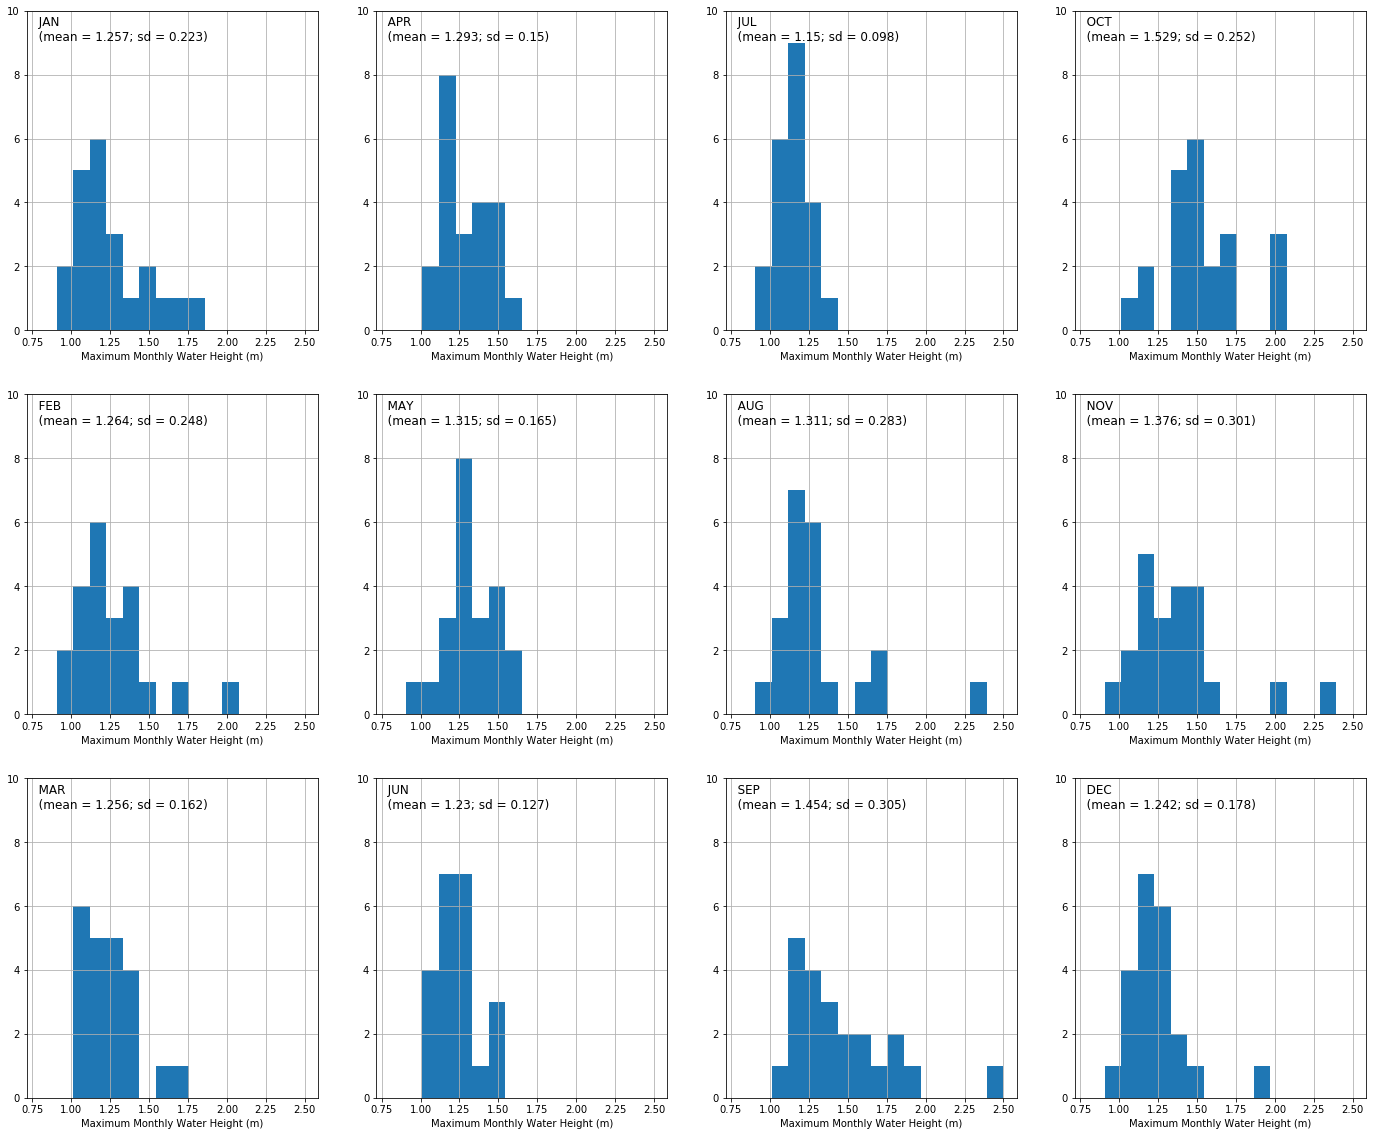

In [8]:
# Histograms and stats on water level data for all 12 months (1996-2017)
months = list(wlev_clean_df.columns[1:])
hist_pos = [1,5,9,2,6,10,3,7,11,4,8,12]

fig=plt.figure(figsize=(24,20))

for m in range(len(months)):
    
    # monthly stats
    this_data = wlev_clean_df.iloc[:,m+1]
    this_mean = np.around(np.mean(this_data),decimals=3)
    this_std = np.around(np.std(this_data),decimals=3)

    # plot it up
    ax=fig.add_subplot(3,4,hist_pos[m])    
    this_data.hist(bins=16,ax=ax,range=(0.80,2.5))
    ax.set_ylim(0,10.0)
    ax.set_title('   '+months[m]+'\n   (mean = '+str(this_mean)+'; sd = '+str(this_std)+')',\
                 loc='left', pad=-30)
    ax.set_xlabel('Maximum Monthly Water Height (m)')

plt.show()


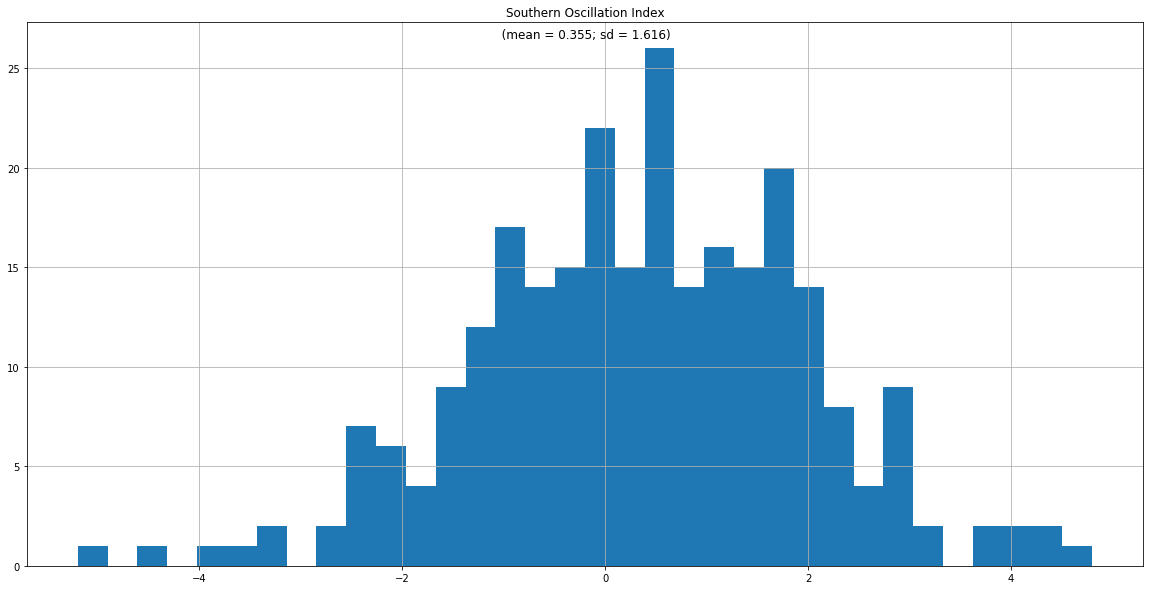

In [104]:
# Histogram and stats for *all* SOI data
# (first restructure dataframe to facilitate this analysis)
#
hist_soi_values=soi_df.iloc[:,1:].values
hist_soi_df=pd.DataFrame(
    {'Southern Oscillation Index':list(hist_soi_values.flatten())}
)

# stats
this_data = hist_soi_df.iloc[:,:]
this_mean = np.around(np.mean(this_data),decimals=3)
this_std = np.around(np.std(this_data),decimals=3)

# plot histogram and stats
hist_soi_df.hist(bins=34,figsize=(20,10))
plt.text(-0.25,26.5,'   (mean = '+str(this_mean[0])+'; sd = '+str(this_std[0])+')',fontsize='12',\
         horizontalalignment='center')

plt.show()

### Lagged datasets: 

    a) One of our goals is to consider the time-lagged nature of the relationship between ENSO dynamics and water 
    level in Norfolk. We will examine lags (in Southern Oscillation Index) of 0, 3, 6, and 9 months. 
    
    b) First, we'll construct our lagged datasets.
    
    c) Then, we'll generate scatterplots and correlations at the four lags to see if any patterns are apparent.

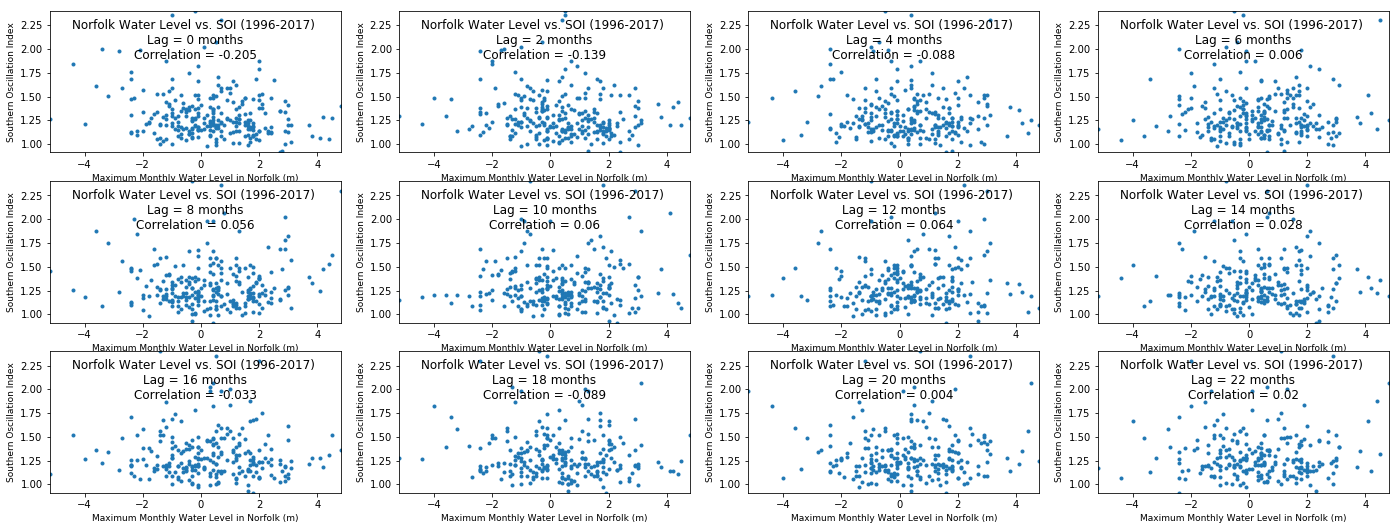

In [246]:
# Scatterplots of Norfolk water level vs. SOI
fig=plt.figure(figsize=(24,12))

min_year = 1996
max_year = 2017

lag_list = []
lag_step = 2
num_lags = 12

for s in range(num_lags):
    lag_list.append(s * lag_step)

soi_lag_0 = soi_df.iloc[:,1:].values.flatten()
wlev_lag_0 = wlev_clean_df.iloc[:,1:].values.flatten()

xrange=(np.min(soi_lag_0),np.max(soi_lag_0))
yrange=(np.min(wlev_lag_0),np.max(wlev_lag_0))

for lag in lag_list:
    ax=fig.add_subplot(4,4,(lag/lag_step)+1)
    
    this_lag_soi_data = soi_lag_0[0:(len(soi_lag_0)-lag)]
    this_lag_wlev_data = wlev_lag_0[(0+lag):]

    x = this_lag_soi_data
    y = this_lag_wlev_data
    r = np.around(np.corrcoef(x,y)[1,0],decimals=3)
        
    plt.scatter(x,y,marker='.')

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    plt.title('Norfolk Water Level vs. SOI ('+str(min_year)+'-'+str(max_year)+') \nLag = '+str(lag)+\
              ' months\nCorrelation = '+str(r), pad=-48)
    plt.xlabel('Maximum Monthly Water Level in Norfolk (m)', fontsize=9)
    plt.ylabel('Southern Oscillation Index', fontsize=9)

plt.show()

### Finding #1: in this case, there is a weakly negative correlation at zero lag between SOI and water level at Sewell's Point in Norfolk; this correlation mostly gets weaker over time. This is contrary to our initial expectation that there would be something of a time delay between ENSO correlates and water level in Norfolk. 

### Linear regression of water level vs. SOI at lag = 0 confirms a negative slope. The large intercept (~1.3 m above the gauge's reference level) is likely indicative of our use of monthly maxima to quantify water levels.

In [250]:
reg_fit = np.polyfit(soi_lag_0,wlev_lag_0,1)
m = reg_fit[0]
b = reg_fit[1]


print('Slope of regression fit:\t',m)
print('Intercept:\t\t\t',b)

Slope of regression fit:	 -0.030471678589686545
Intercept:			 1.3172774373170937


### Let's now see how the data cluster using k-means. Perhaps the clusters will help further explain patterns in our dataset.

In [ ]:
# Scatter plots for different time periods
fig=plt.figure(figsize=(24,12))

teams = np.unique(payroll_winperc['teamID'])

min_yr = 1990
time_step = 5

for p in range(5):
    lbound = min_yr + (p * time_step)
    ubound = lbound + time_step
    ax=fig.add_subplot(3,2,(p+1))
    for t in range(len(teams)):
        this_teams_data = [r for r in range(len(payroll_winperc['payroll'])) \
                           if payroll_winperc['teamID'][r] == teams[t] and payroll_winperc['yearID'][r] >= lbound and \
                           payroll_winperc['yearID'][r] < ubound]
        # Exclude teams not in existence during time period of interest
        if len(this_teams_data) < 1:
            continue
        x = payroll_winperc['payroll'][this_teams_data].mean()/1.0e06
        y = payroll_winperc['winperc'][this_teams_data].mean()
        #
        plt.scatter(x,y,marker='.',label=teams[t])
        plt.annotate(teams[t], (x, y), fontsize=9)
    plt.title('MLB Winning Percentage vs. Payroll ('+str(lbound)+'-'+str(ubound-1)+')', pad=-11)
    plt.xlabel('Mean Payroll ($MM)')
    plt.ylabel('Mean Winning Percentage')
    ax.set_xlim(0,225)
    ax.set_ylim(35,65)

plt.show()

In [ ]:
fig=plt.figure(figsize=(24,12))

x = payroll_winperc_stdized['standardized_payroll']
y = payroll_winperc_stdized['winperc']

# Scatter plot for all teams and years
plt.scatter(x,y)
plt.title('MLB Winning Percentage vs. Standardized Annual Payroll (1985-2014)')
plt.xlabel('Standardized Annual Payroll (unitless)')
plt.ylabel('Winning Percentage (%)')

# Fit a regression line with np.polyfit(); must first filter out invalid (NaN) entries present in dataframe
valid_data = [r for r in range(len(payroll_winperc_stdized['standardized_payroll'])) \
              if not np.isnan(payroll_winperc_stdized['standardized_payroll'][r])]
x_valid = payroll_winperc_stdized['standardized_payroll'][valid_data]
y_valid = payroll_winperc_stdized['winperc'][valid_data]

reg_fit = np.polyfit(x_valid,y_valid,1)
m = reg_fit[0]
b = reg_fit[1]

# Plot the line
plt.plot(x_valid, b + m * x_valid, 'r-')

plt.show()

print('Slope of regression fit:\t',m)
print('Intercept:\t\t\t',b)

## Findings

## Conclusions and Future Directions